Original Paper: [U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf)

Source: https://github.com/danielgatis/rembg

https://docs.opencv.org/4.x/d9/db0/tutorial_hough_lines.html

https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga2a671611e104c093843d7b7fc46d24af

https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from google.colab.patches import cv2_imshow

In [ ]:
!pip install rembg[gpu]

In [3]:
from rembg import remove

In [4]:
def remove_background_img(img_dir, show=False, resize_shape=None, save=True, save_name="img"):
  # Processing the image
  input = cv2.imread(img_dir)
  input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

  # Removing the background from the given Image
  output_img = remove(input)

  # Load the segmented image
  output_img_gray = tf.image.rgb_to_grayscale(output_img[:,:,:3])
  output_img_gray = np.squeeze(output_img_gray)

  # Find the coordinates of the non black pixels
  nonzero_pixels = np.argwhere(output_img_gray > 0)

  # Get the bounding box for the image
  y_min, x_min = np.min(nonzero_pixels, axis=0)
  y_max, x_max = np.max(nonzero_pixels, axis=0)

  # Crop the masked region from the original image
  cropped_img = output_img[y_min:y_max+1, x_min:x_max+1]
  cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

  if resize_shape != None:
    cropped_img = (tf.image.resize(cropped_img, resize_shape)).numpy()

  # Save or display the cropped PCB image
  if save:
    save_name = str(save_name) + ".png"
    cv2.imwrite(save_name, cropped_img)
  if show:
    cv2_imshow(cropped_img)

In [5]:
# remove_background_img('/content/../../../img.JPG', show=True, save_name='img_cropped')

In [6]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'

In [7]:
import os

BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

In [8]:
import glob

def get_image_file_list(dir, ext):
    formats = ['jpg', 'png', 'jpeg', 'JPG', 'JPEG', 'PNG']
    img_list = []

    if ext in formats:
        rgx_for_img = dir + "/*." + ext
        img_list = glob.glob(rgx_for_img)

    return img_list

In [9]:
img_files = get_image_file_list(BD67_NORMAL_FRONT_PATH, 'JPG')
rotated_img_files = get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'JPG')
all_img_files = img_files + rotated_img_files

In [10]:
save_name = str(img_files[0][-12:-4]) + '_cropped'
save_name

'IMG_9195_cropped'

In [11]:
print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  108
Number of all image files:  218


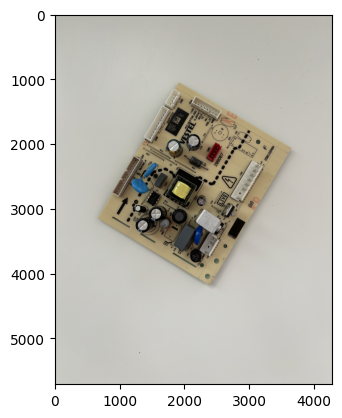

In [12]:
rotated_image = cv2.imread(rotated_img_files[0])
rotated_image = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)
plt.imshow(rotated_image)

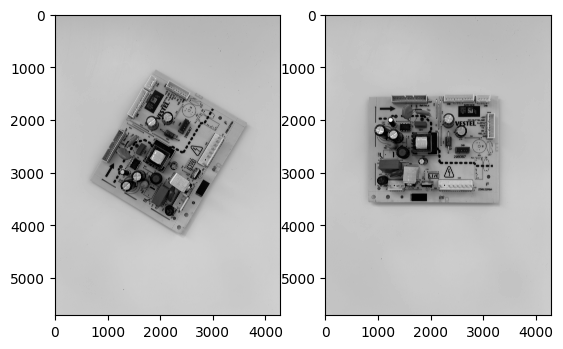

In [13]:
rotated_image = cv2.imread(rotated_img_files[0], cv2.IMREAD_GRAYSCALE)
original_image = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(rotated_image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(original_image, cmap='gray')

In [31]:
def flatten_object_in_image(img_file, ref_img_file, dist_factor=0.75, num_matches=4, show=False, save_dir=None, verbose=0):
  good_matches = []

  # Read soruce image file and the target image file
  original_img = cv2.imread(img_file)
  src_img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
  dst_img = cv2.imread(ref_img_file, cv2.IMREAD_GRAYSCALE)

  # Calculate center point of the source image
  height, width = src_img.shape[:2]
  centerX, centerY = (width // 2, height // 2)

  # Create a SIFT (Scale-Invariant Feature Transform) detector
  sift = cv2.SIFT_create()

  # Create a Brute-Force Matcher
  bf = cv2.BFMatcher()

  # Find the keypoints and descriptors in both images
  kp1, des1 = sift.detectAndCompute(src_img, None)
  kp2, des2 = sift.detectAndCompute(dst_img, None)

  # Match the descriptors
  matches = bf.knnMatch(des1, des2, k=2)

  # Apply ratio test to obtain good matches
  for m, n in matches:
      if m.distance < dist_factor * n.distance:
          good_matches.append(m)

  if len(good_matches) > num_matches:
      src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
      dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

      # Calculate the transformation matrix
      M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

      # Calculate the rotation angle
      rotation_angle = np.arctan2(M[1, 0], M[0, 0])

      # Convert the rotation angle from radians to degrees
      rotation_angle_degrees = np.degrees(rotation_angle)

      if verbose:
        print(f"Rotation Angle: {rotation_angle_degrees} degrees")
  else:
      print("Not enough good matches found. More similar reference image is needed")

  rot_matrix = cv2.getRotationMatrix2D((centerX, centerY), (360-rotation_angle_degrees), 1.0)

  # rotated image
  rotated_image = cv2.warpAffine(original_img, rot_matrix, (width, height))

  if save_dir != None:
    cv2.imwrite(save_dir, rotated_image)

  # display image
  if show:
    cv2_imshow(rotated_image)

In [29]:
flatten_object_in_image(rotated_img_files[0], img_files[1], show=False, save_dir="img1.png")

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 31.3GB/s]


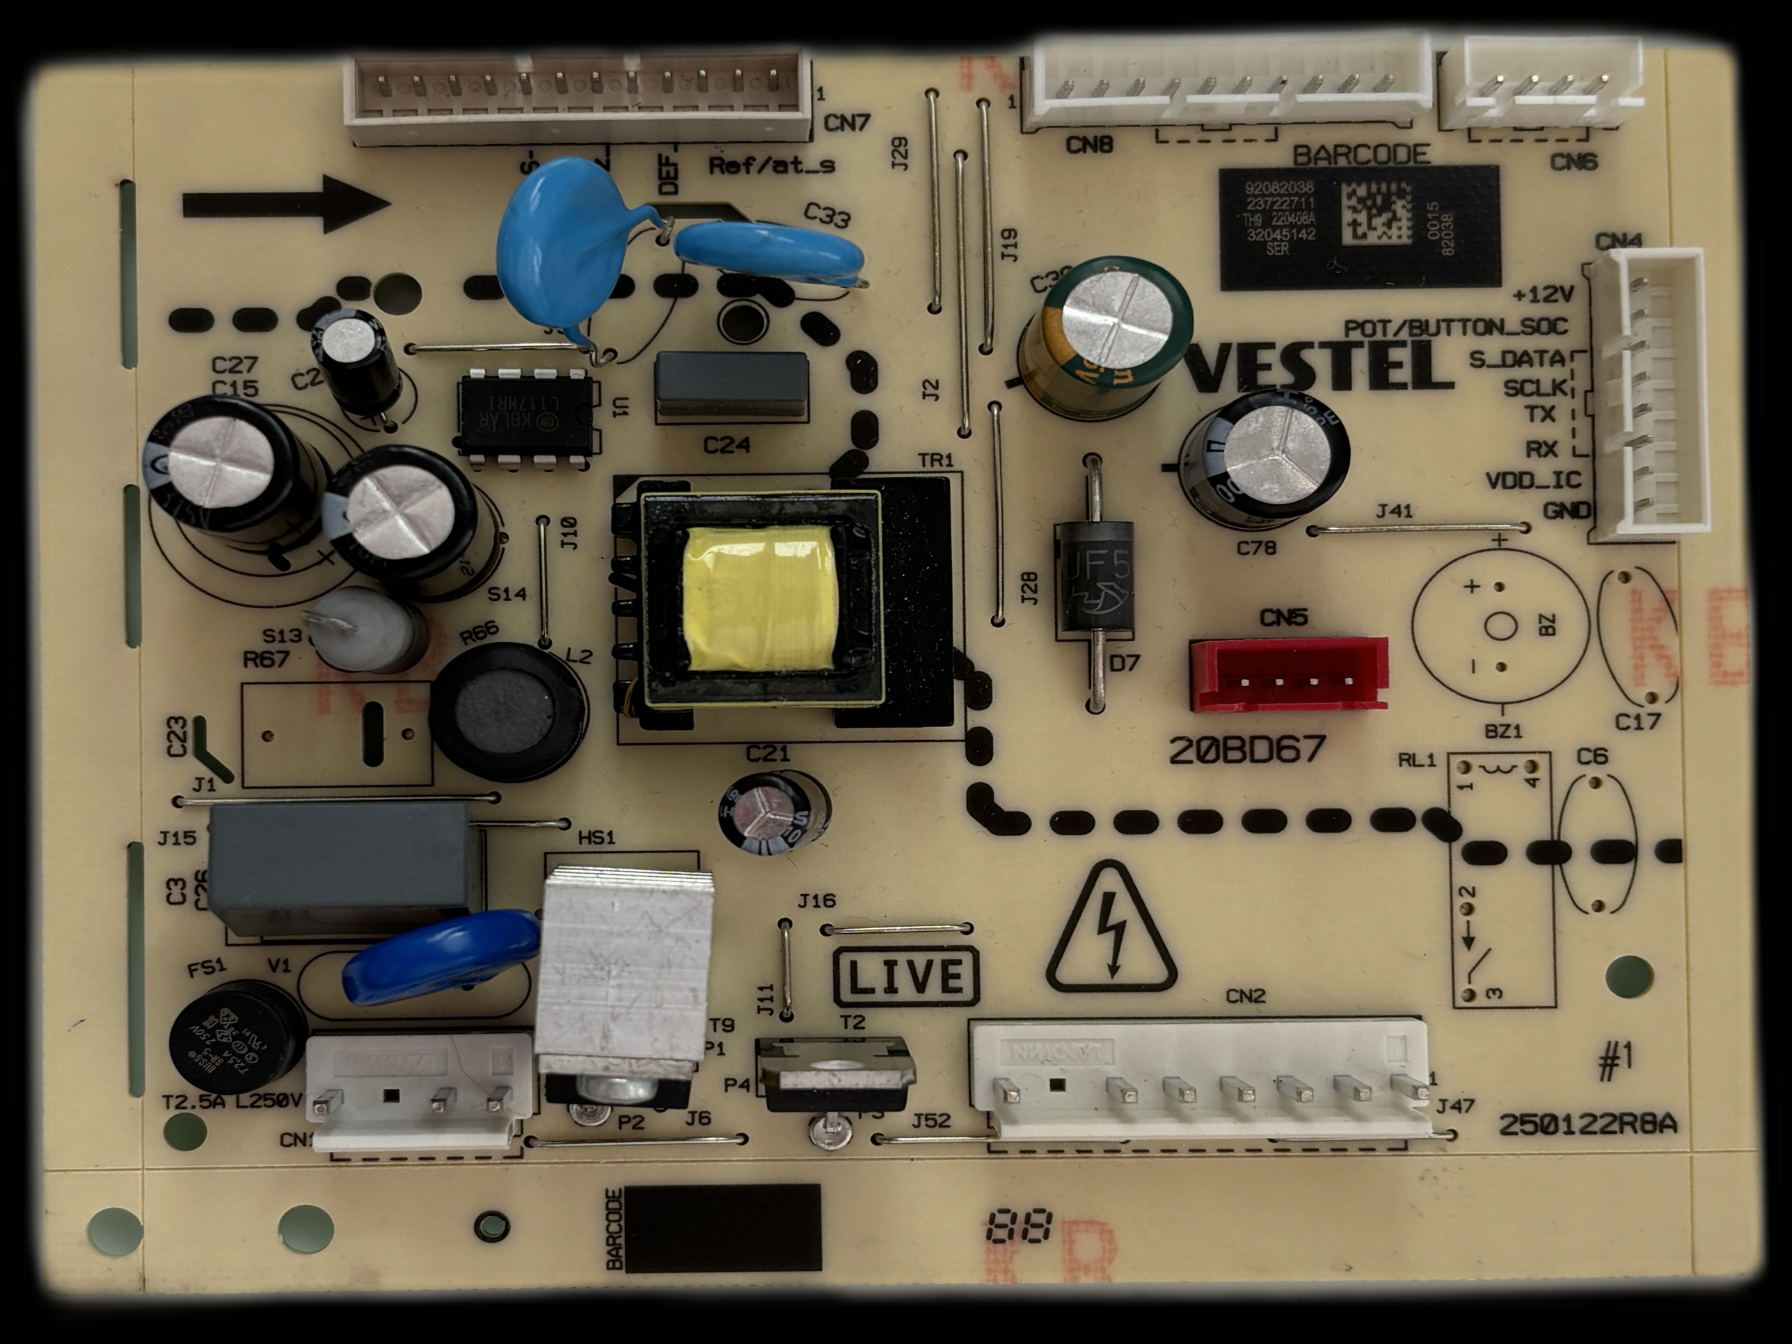

In [30]:
remove_background_img('/content/img1.png', show=True, resize_shape=(1344, 1792), save_name='img1_cropped')

In [ ]:
for ix in range(len(img_files)):
  save_path = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset/defect_free/Front/cropped/'
  save_name_str = save_path + str(img_files[ix][-12:-4]) + '_cropped'
  remove_background_img(img_files[ix], show=False, resize_shape=(1344, 1792), save_name=save_name_str)